# Creating product categories
In this notebook we are going to create clusters from our data. These will serve us as product categories.

Steps:
   1. Load data
   2. Cleaning data
   3. Extract keywords from product description as identifiers for our products.
   4. Create a count vectorizer matrix using the keywords
   5. Build clusters using kmods algorithm

### Imports

In [269]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score, silhouette_samples

## 1. Load data

In [2]:
data = pd.read_csv('../data/data.csv')

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## 2. Cleaning the data

We need all product description. First, we are going to remove descriptions that are no products using StockCode variable.

In [181]:
are_product = data['StockCode'].apply(lambda code: code[0].isnumeric())
price_not_zero = data['UnitPrice'] > 0
df = data[are_product & price_not_zero][['Description', 'UnitPrice']]

In [182]:
df.shape

(536429, 2)

Now, we need to get rid of missing values in Description column, because is the feature we use to create the counts matrix.
\
Also we will drop duplicates.

In [183]:
df.isna().sum()

Description    0
UnitPrice      0
dtype: int64

In [184]:
df = df.dropna().drop_duplicates(subset='Description')

In [185]:
df.isna().sum()

Description    0
UnitPrice      0
dtype: int64

In [186]:
df.shape

(4019, 2)

In [187]:
df.head()

,Description,UnitPrice
0,WHITE HANGING HEART T-LIGHT HOLDER,2.55
1,WHITE METAL LANTERN,3.39
2,CREAM CUPID HEARTS COAT HANGER,2.75
3,KNITTED UNION FLAG HOT WATER BOTTLE,3.39
4,RED WOOLLY HOTTIE WHITE HEART.,3.39


## 3. Extracting product names from descriptions

Now we will extract nouns from product descriptions using NLTK module for pos tagging, stemming and tokenizing words.

In [188]:
"""
products (dict):    
    key:      
        nouns from descriptions

    values: {
            count: noun freq in the data
            words: list of words associated with the product
            keyword: product keyword
        }
"""
products = {} 

def update_counter(pos_tags):
    """ 
        Process POS tagged words list to get product 
        names and counts and update keywords dict 
    """
    stemmer = nltk.stem.snowball.SnowballStemmer('english')
    
    for word, tag in pos_tags:
            if word == 'necklac':
                word = 'necklace'
            if 'NN' in tag:
                root = stemmer.stem(word)
                if root in products.keys():
                    products[root]['count'] += 1
                    if word not in products[root]['words']:
                        products[root]['words'].append(word)
                        if len(word) < len(products[root]['keyword']):
                            products[root]['keyword'] = word
                else:
                    products[root] = {'count': 1, 'words':[word], 'keyword':word}

In [189]:
%%time
products = {}
df['Description'].str.lower().apply(nltk.word_tokenize).apply(nltk.pos_tag).apply(update_counter)

CPU times: user 1.76 s, sys: 7.72 ms, total: 1.77 s
Wall time: 1.77 s


0         None
1         None
2         None
3         None
4         None
          ... 
507867    None
512588    None
527065    None
537621    None
540421    None
Name: Description, Length: 4019, dtype: object

Let's plot most frequent words

In [190]:
products['necklac']

{'count': 100, 'words': ['necklace'], 'keyword': 'necklace'}

In [191]:
word_counts = [(value['keyword'],value['count']) for value  in products.values()]
word_counts.sort(key=lambda x: x[1], reverse=True)
word_counts[:5]

[('heart', 269), ('vintage', 215), ('set', 207), ('pink', 199), ('bag', 167)]

In [192]:
word_counts_df = pd.DataFrame(word_counts, columns=['word', 'count'])

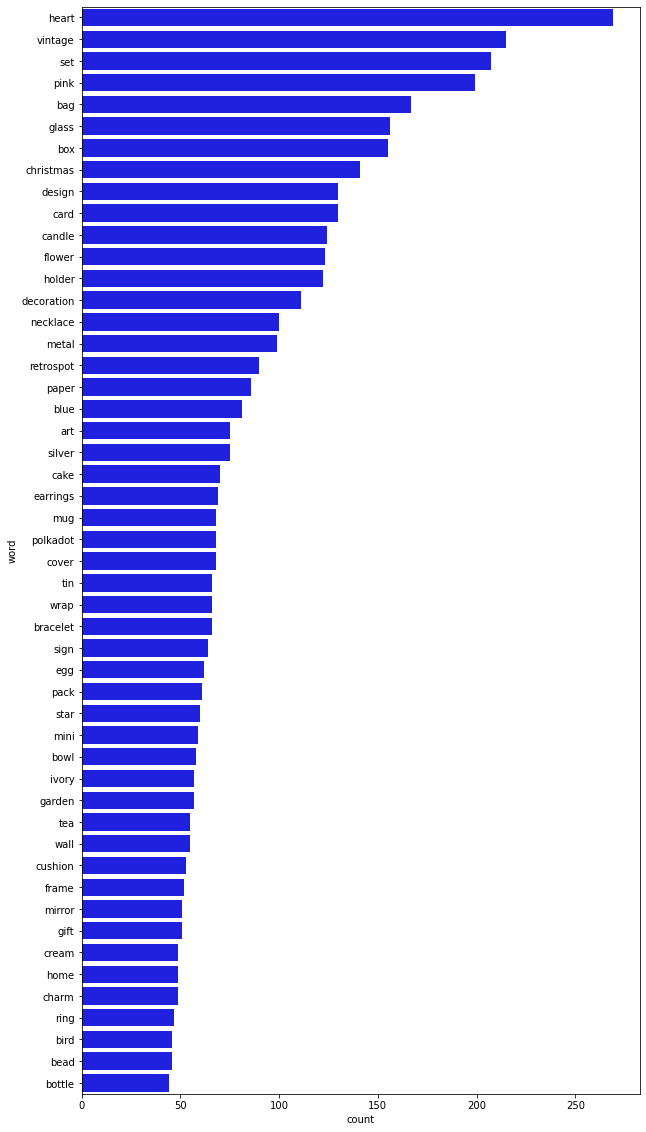

In [193]:
plt.figure(figsize=(10, 20))
sns.barplot(x='count', y='word', data=word_counts_df[:50], color='blue');

* There are some words that are not nouns (colors as pink, blue...)

Removing invalid words

In [194]:
len_greater_2 = word_counts_df['word'].str.len() > 2
count_greater_13 = word_counts_df['count'] > 13
nouns = ~word_counts_df['word'].isin(['pink', 'blue'])

keywords = word_counts_df[len_greater_2 & count_greater_13 & nouns]['word'].values

In [195]:
# Final keywords for the count vectorizer
keywords, len(keywords)

(array(['heart', 'vintage', 'set', 'bag', 'glass', 'box', 'christmas',
        'design', 'card', 'candle', 'flower', 'holder', 'decoration',
        'necklace', 'metal', 'retrospot', 'paper', 'art', 'silver', 'cake',
        'earrings', 'mug', 'polkadot', 'cover', 'tin', 'wrap', 'bracelet',
        'sign', 'egg', 'pack', 'star', 'mini', 'bowl', 'ivory', 'garden',
        'tea', 'wall', 'cushion', 'frame', 'mirror', 'gift', 'cream',
        'home', 'charm', 'ring', 'bird', 'bead', 'bottle', 'clock',
        'paisley', 'letter', 'party', 'gold', 'wood', 'ribbon', 'garland',
        'hook', 'jar', 'butterfly', 'easter', 'drawer', 'water', 'cup',
        'zinc', 'photo', 'bell', 'plate', 'tray', 'pencil', 'skull',
        'spot', 'children', 'enamel', 'case', 'round', 'tissue',
        'sweetheart', 'stand', 'sticker', 'diamante', 'drop', 'spaceboy',
        'light', 'cutlery', 'tree', 'union', 'rabbit', 'magnet', 'pantry',
        'colour', 'lunch', 'pot', 'book', 'baroque', 'storage', 'h

## 3. Count Vectorizer

In [214]:
vectorizer = CountVectorizer(vocabulary=keywords)
word_counts = vectorizer.fit_transform(df['Description'])

Let's add range price as new feature

In [197]:
bins = [0, 1, 2, 3, 5, 10, np.inf]
price_ranges = pd.cut(df['UnitPrice'], bins)
price_ranges.value_counts()

(1.0, 2.0]     946
(2.0, 3.0]     758
(0.0, 1.0]     739
(3.0, 5.0]     702
(5.0, 10.0]    624
(10.0, inf]    250
Name: UnitPrice, dtype: int64

In [203]:
price_matrix = pd.get_dummies(price_ranges).values
price_matrix

array([[0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0]], dtype=uint8)

In [215]:
word_counts.shape, price_matrix.shape

((4019, 182), (4019, 6))

In [217]:
X = np.concatenate([word_counts.toarray(), price_matrix], axis=1)
X.shape

(4019, 188)

## 4. Create clusters

The most suitable metric for the calculation of distances is the Hamming's metric. So we will use kmodes module to create the clusters

In [220]:
km = KModes()

In [262]:
n_clusters = np.arange(3, 10)
for n in n_clusters:
    km = KModes(n_clusters=n,  init='Huang', n_init=5)
    km.fit(X)
    clusters = km.predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    print(f'For n_clusters = {n}, The average silhouette_score is: {silhouette_avg}')

For n_clusters = 3, The average silhouette_score is: 0.10766310238847605
For n_clusters = 4, The average silhouette_score is: 0.14692263100762784
For n_clusters = 5, The average silhouette_score is: 0.17811488708922968
For n_clusters = 6, The average silhouette_score is: 0.15992461510554204
For n_clusters = 7, The average silhouette_score is: 0.17979765773293538
For n_clusters = 8, The average silhouette_score is: 0.11895672385292642
For n_clusters = 9, The average silhouette_score is: 0.12672118892496648


In [265]:
import matplotlib.cm as cm

def plot_sihouette(X, n_clusters):
    km = KModes(n_clusters=n_clusters,  init='Huang', n_init=5)
    cluster_labels = km.fit_predict(X)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.set_xlim([-0.1, 1])
    ax.set_ylim(0, len(X) + (n_clusters + 1) * 10 )
    
    y_lower = 10
    for i in range(n_clusters):
        samples_i = sample_silhouette_values[cluster_labels == i]
        samples_i.sort()
        
        size_cluster_i = samples_i.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / n_clusters)
        
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                        0, samples_i, facecolor=color, edgecolor=color,
                        alpha=0.7)
        # cluster labels
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        # compute the new y_lower for next plot
        y_lower = y_upper + 10

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        
        

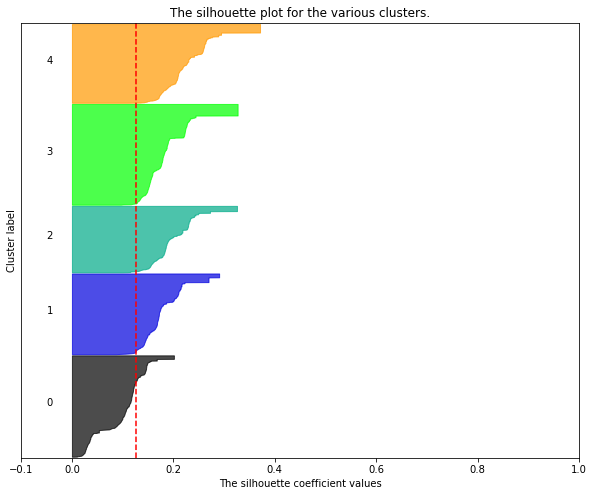

In [266]:
plot_sihouette(X, n_clusters=5)

5 clusters seems the best candidate

In [ ]:
def plot_wordclouds(cluster_labels, count_dict):
    fig, axs = plt.subplots(2, 3)
    
    wc = Wordcloud